# Lab 2 Report: 
## MNIST Classification with MLP

In [1]:
# Import necessary packages

import matplotlib.pyplot as plt

import torch
import torchvision
import numpy as np

In [2]:
from IPython.display import Image # For displaying images in colab jupyter cell

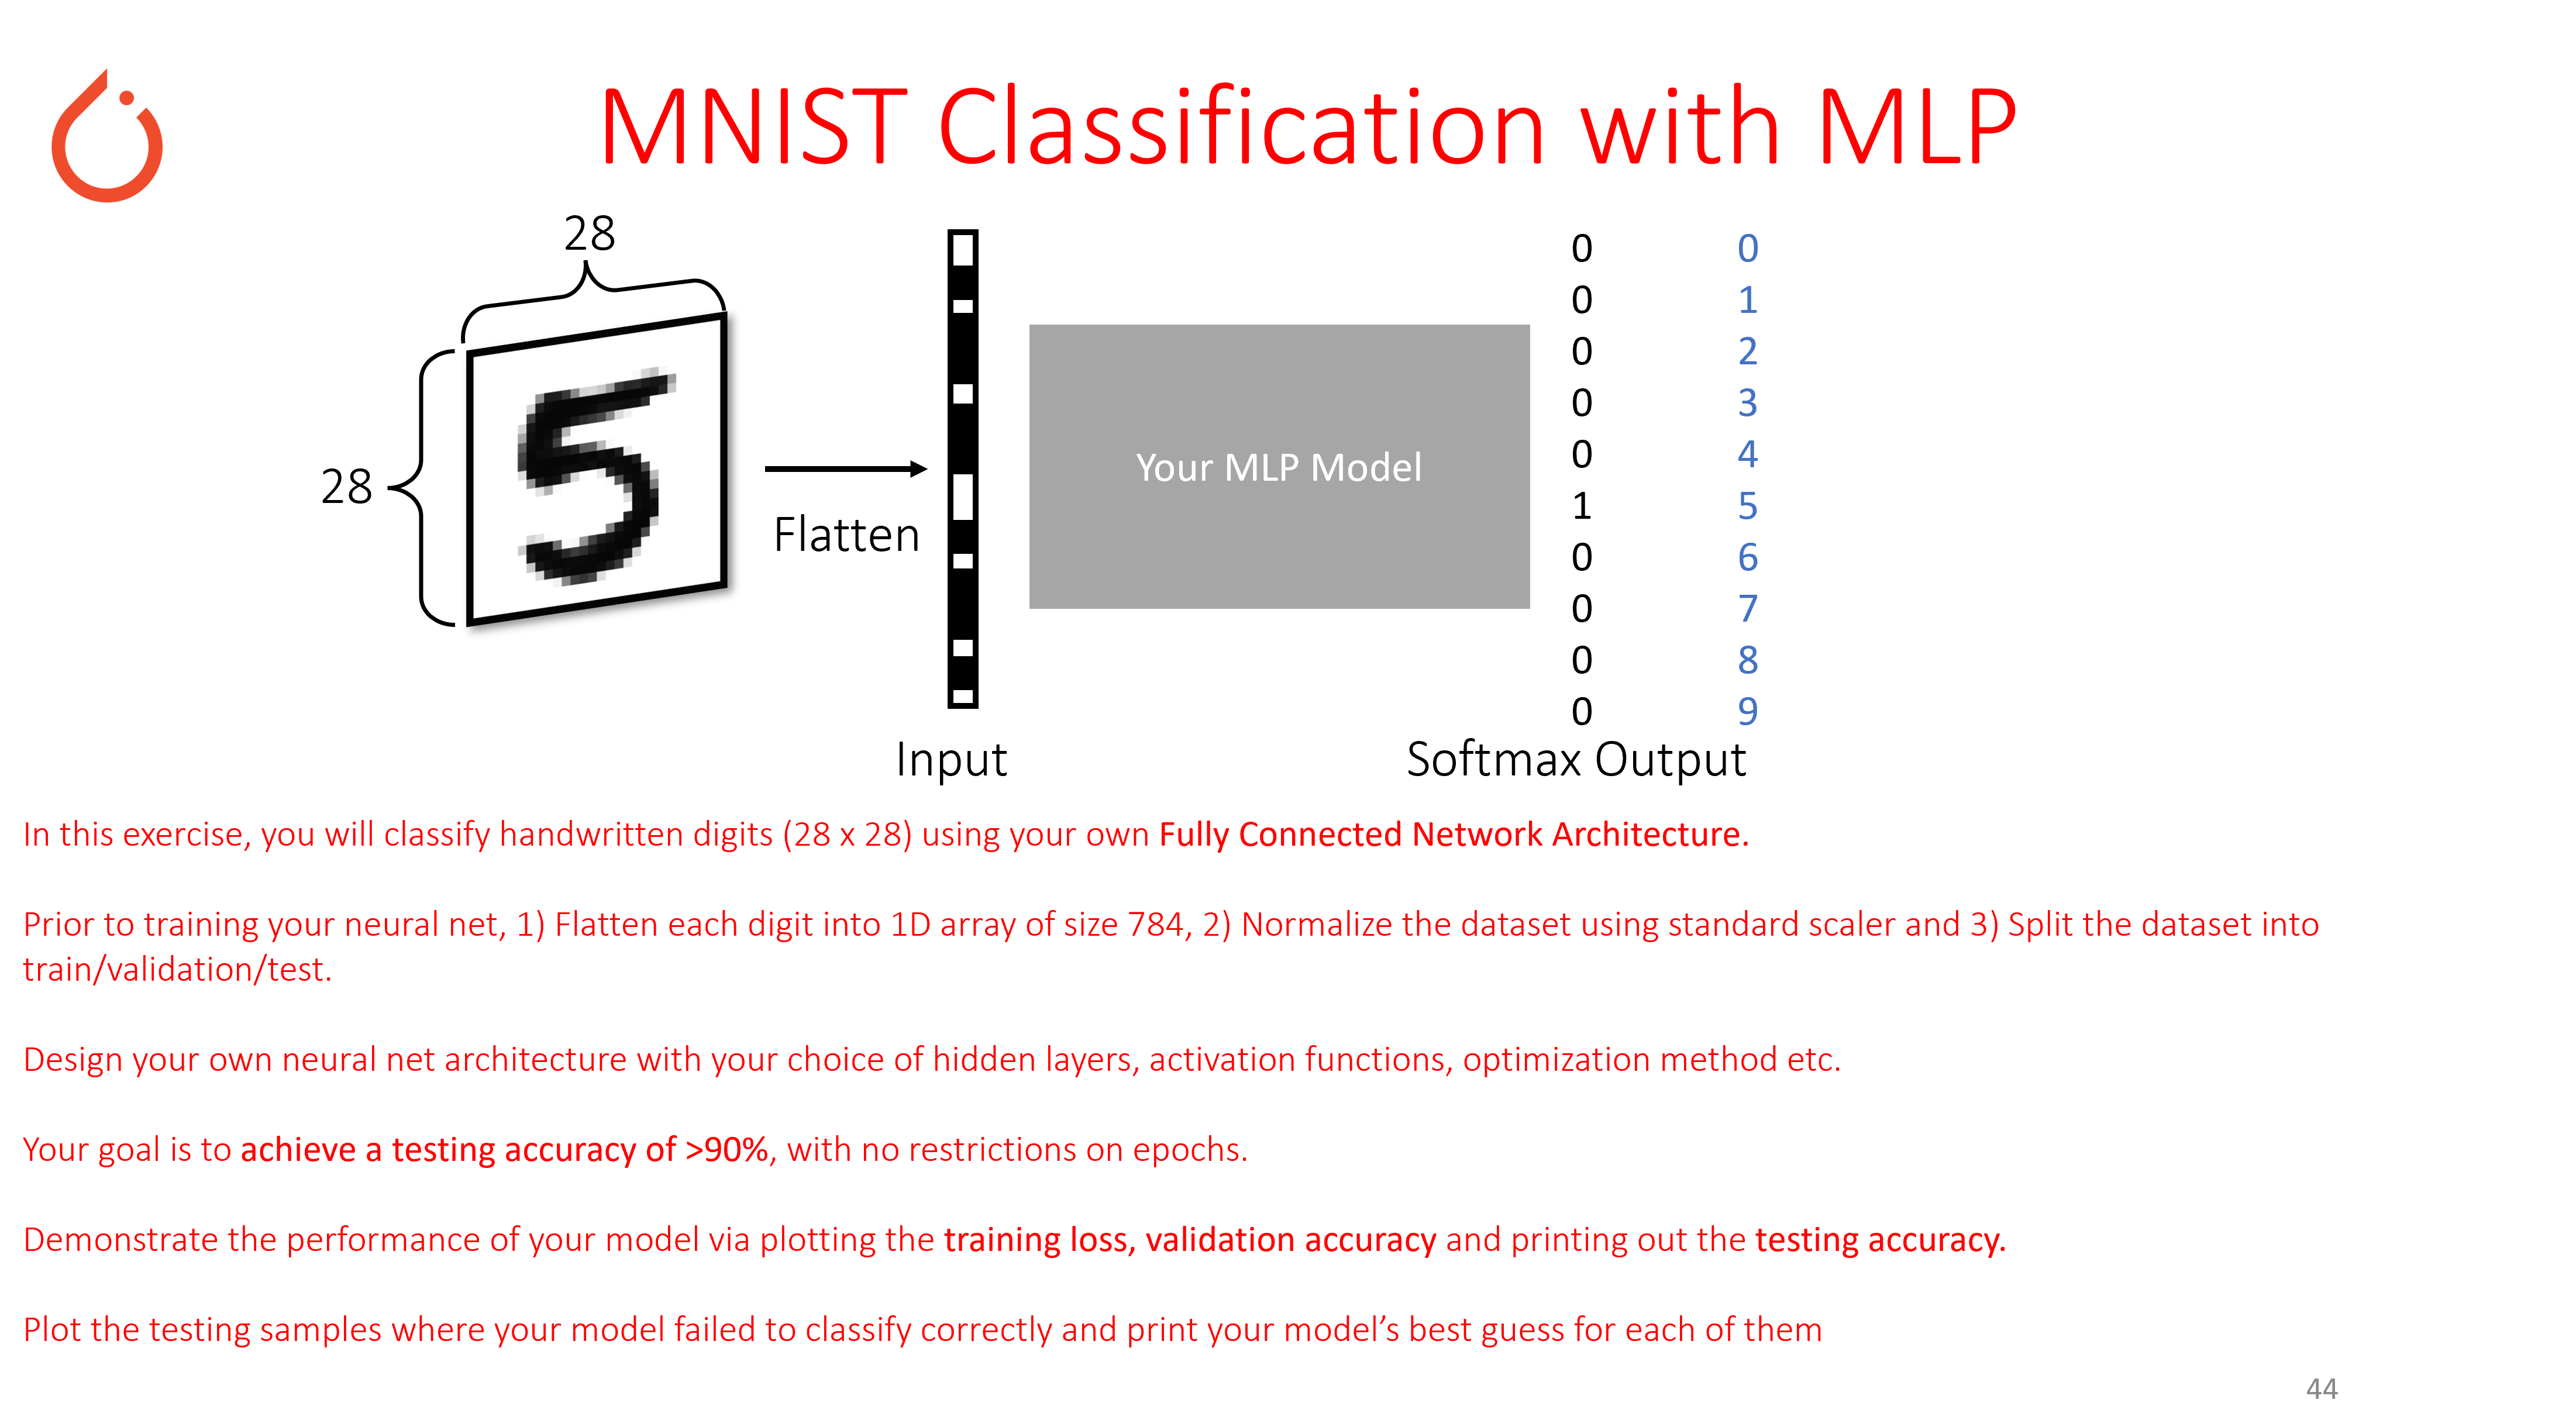

In [3]:
Image('lab2_exercise.PNG', width = 1000)

### Prepare Data

In [4]:
# Load MNIST Dataset in Numpy

# 1000 training samples where each sample feature is a greyscale image with shape (28, 28)
# 1000 training targets where each target is an integer indicating the true digit

# ***Renaming to avoid overwriting***
og_mnist_train_features = np.load('mnist_train_features.npy') 
og_mnist_train_targets = np.load('mnist_train_targets.npy')

# 100 testing samples + targets
og_mnist_test_features = np.load('mnist_test_features.npy')
og_mnist_test_targets = np.load('mnist_test_targets.npy')

# Print the dimensions of training sample features/targets
print(og_mnist_train_features.shape, og_mnist_train_targets.shape)
# Print the dimensions of testing sample features/targets
print(og_mnist_test_features.shape, og_mnist_test_targets.shape)

(1000, 28, 28) (1000,)
(100, 28, 28) (100,)


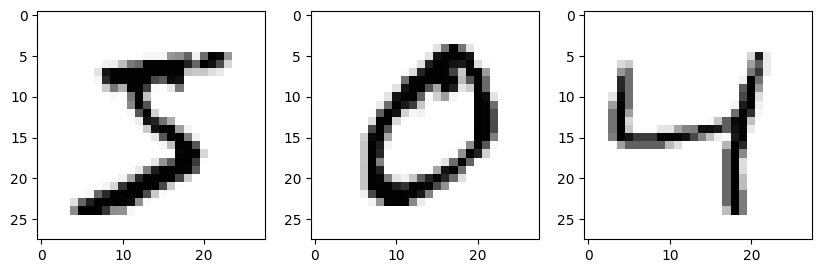

In [5]:
# Let's visualize some training samples

plt.figure(figsize = (10, 10))

plt.subplot(1,3,1)
plt.imshow(og_mnist_train_features[0], cmap = 'Greys')

plt.subplot(1,3,2)
plt.imshow(og_mnist_train_features[1], cmap = 'Greys')

plt.subplot(1,3,3)
plt.imshow(og_mnist_train_features[2], cmap = 'Greys')

In [6]:
# Reshape features via flattening the images
# The reshaped training/testing features should have shape (1000, 784) and (100, 784) respectively
# np.reshape() function could be useful here

reshaped_mnist_train_features = np.reshape(og_mnist_train_features, [1000,784])
reshaped_mnist_test_features = np.reshape(og_mnist_test_features, [100,784])

print(reshaped_mnist_train_features.shape, reshaped_mnist_test_features.shape)

(1000, 784) (100, 784)


In [7]:
# Scale the dataset according to standard scaling
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

scaled_mnist_train_features = scaler.fit_transform(reshaped_mnist_train_features)
scaled_mnist_test_features = scaler.fit_transform(reshaped_mnist_test_features)

In [8]:
# Initially split dataset into Train (900 samples), Validation (100 samples), Testing (100 samples)

from sklearn.model_selection import train_test_split


# split_scaled_mnist_train_features, split_mnist_test_features, split_mnist_train_target, split_mnist_test_target = train_test_split(
#     scaled_mnist_train_features, og_mnist_test_features, test_size=0.1)

split_mnist_train_features, split_mnist_validation_features, split_mnist_train_targets, split_mnist_validation_targets = train_test_split(
    scaled_mnist_train_features, og_mnist_train_targets, test_size=0.1, random_state=42)


#split_mnist_validation_features = # YOUR CODE HERE
#split_mnist_validation_targets = # YOUR CODE HERE

#mnist_train_features = # YOUR CODE HERE
#mnist_train_targets = # YOUR CODE HERE

### Define Model

In [9]:
class mnistClassification(torch.nn.Module):
    
    def __init__(self, input_dim, output_dim, hidden_dim, dropout_rate=0.2): # Feel free to add hidden_dim as parameters here
        
        super(mnistClassification, self).__init__()
        
        self.layer1 = torch.nn.Linear(input_dim, hidden_dim)
        self.dropout = torch.nn.Dropout(dropout_rate)
        self.layer2 = torch.nn.Linear(hidden_dim, output_dim)
       
        
    def forward(self, x):
        
        out1 = torch.nn.functional.relu(self.layer1(x))
        out1 = self.dropout(out1)
        output = self.layer2(out1)
      
        
        return output

# Hidden dimm paramter needed later         
model = mnistClassification(input_dim=784, output_dim=10, hidden_dim=512)

In [10]:
# # No Dropout

# class mnistClassification(torch.nn.Module):
    
#     def __init__(self, input_dim, output_dim, hidden_dim): # Feel free to add hidden_dim as parameters here
        
#         super(mnistClassification, self).__init__()
        
#         self.layer1 = torch.nn.Linear(input_dim, hidden_dim)
#         self.layer2 = torch.nn.Linear(hidden_dim, output_dim)
       
        
#     def forward(self, x):
        
#         out1 = torch.nn.functional.relu(self.layer1(x))      
#         output = self.layer2(out1)

        
#         return output

# # Hidden dimm paramter needed later         
# model = mnistClassification(input_dim=784, output_dim=10, hidden_dim=512)

In [11]:
# # No hidden layers

# class mnistClassification(torch.nn.Module):
    
#     def __init__(self, input_dim, output_dim): # Feel free to add hidden_dim as parameters here
        
#         super(mnistClassification, self).__init__()
        
#         self.layer1 = torch.nn.Linear(input_dim, output_dim)

       
        
#     def forward(self, x):

#         output = self.layer1(x)
        
#         return output

# model = mnistClassification(input_dim=784, output_dim=10)

### Define Hyperparameters

In [12]:
# Initialize our neural network model with input and output dimensions
# input Dimmensions = 784 (28x28)
# output dimensions = 10 (0-9)
# hidden dimensions = powers of 2s should work best


# Define the learning rate and epoch 
learning_rate = 0.001
epochs = 50
batchsize = 128 # mini-batch gradient

# Define loss function and optimizer
loss_func = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=0.001) #added weight decay
#optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9) 


# Run this line if you have PyTorch GPU version
if torch.cuda.is_available():
    model.cuda()

model

mnistClassification(
  (layer1): Linear(in_features=784, out_features=512, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
  (layer2): Linear(in_features=512, out_features=10, bias=True)
)

### Identify Tracked Values

In [13]:
# Placeholders for training loss and validation accuracy during training
# Training loss should be tracked for each iteration (1 iteration -> single forward pass to the network)
# Validation accuracy should be evaluated every 'Epoch' (1 epoch -> full training dataset)
# If using batch gradient, 1 iteration = 1 epoch

train_loss_list =  np.zeros((epochs, ))
validation_accuracy_list = np.zeros((epochs, ))

### Train Model

In [14]:
import tqdm

# Convert the training, validation, testing dataset (NumPy arrays) into torch tensors

train_inputs = torch.from_numpy(split_mnist_train_features).float()
train_targets = torch.from_numpy(split_mnist_train_targets).long()

validation_inputs = torch.from_numpy(split_mnist_validation_features).float()
validation_targets = torch.from_numpy(split_mnist_validation_targets).long()

testing_inputs = torch.from_numpy(scaled_mnist_test_features).float()
testing_targets = torch.from_numpy(og_mnist_test_targets).long()



# Training Loop ---------------------------------------------------------------------------------------

for epoch in tqdm.trange(epochs):
    
    optimizer.zero_grad()
    train_outputs = model(train_inputs)
    loss = loss_func(train_outputs, train_targets)
    train_loss_list[epoch] = loss.item()
    loss.backward()
    optimizer.step()
    
    # Compute Validation Accuracy ----------------------------------------------------------------------
    with torch.no_grad():
        validation_outputs = model(validation_inputs)
        correct = (torch.argmax(validation_outputs, dim=1) == validation_targets).type(torch.FloatTensor)
        validation_accuracy_list[epoch] = correct.mean()
    


100%|██████████| 50/50 [00:00<00:00, 140.90it/s]


### Visualize and Evaluate Model

In [15]:
# Import seaborn for prettier plots

import seaborn as sns

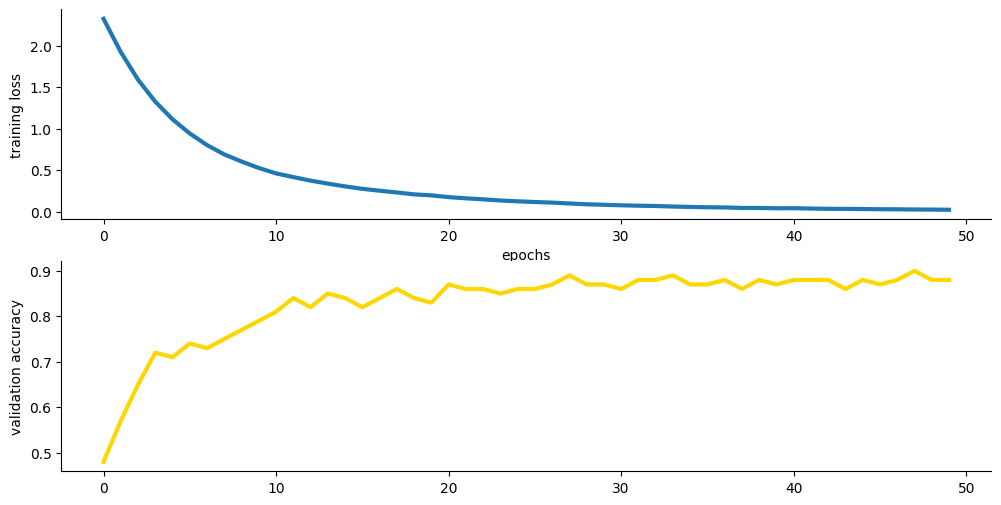

In [16]:
# Visualize training loss

plt.figure(figsize = (12, 6))

# Visualize training loss with respect to iterations (1 iteration -> single batch)
plt.subplot(2, 1, 1)
plt.plot(train_loss_list, linewidth = 3)
plt.ylabel("training loss")
plt.xlabel("epochs")
sns.despine()

# Visualize validation accuracy with respect to epochs
plt.subplot(2, 1, 2)
plt.plot(validation_accuracy_list, linewidth = 3, color = 'gold')
plt.ylabel("validation accuracy")
sns.despine()

In [17]:
# Compute the testing accuracy 

y_pred_test = model(testing_inputs)
correct = (torch.argmax(y_pred_test, dim=1) == testing_targets).type(torch.FloatTensor)
testing_accuracy = str(correct.mean().numpy()*100)


print(f"Optimizer: {optimizer.__class__.__name__}")
print(f"Testing Accuracy: {testing_accuracy:s}%")
print(f"Learning Rate: {learning_rate}")
print(f"Epochs: {epochs}")
print(f"Batch Size: {batchsize}")
print(f"Loss Function: {loss_func}")




Optimizer: Adam
Testing Accuracy: 93.0%
Learning Rate: 0.001
Epochs: 50
Batch Size: 128
Loss Function: CrossEntropyLoss()


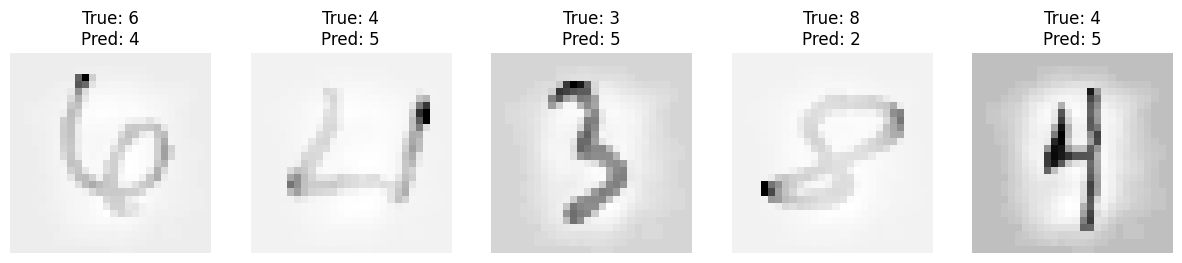

In [18]:
# Plot 5 incorrectly classified testing samples and print the model predictions for each of them
# You can use np.reshape() to convert flattened 1D array (768,) -> (28, 28)

# Get predictions and find incorrect ones
with torch.no_grad():
    predictions = torch.argmax(model(testing_inputs), dim=1)
incorrect_indices = torch.where(predictions != testing_targets)[0][:5]

# Plot the images
plt.figure(figsize=(15, 3))
for i, idx in enumerate(incorrect_indices):
    plt.subplot(1, 5, i+1)
    image = np.reshape(scaled_mnist_test_features[idx.numpy()], (28, 28))
    plt.imshow(image, cmap='Greys')
    plt.title(f'True: {testing_targets[idx].item()}\nPred: {predictions[idx].item()}')
    plt.axis('off')
plt.show()


# Log of runs

## Run 1
- Optimizer: Adam
- Testing Accuracy: 55.0%
- Learning Rate: 0.005
- Epochs: 20
- Batch Size: 128
- Loss Function: CrossEntropyLoss()

## Run 2
**Fixed scaled target data parameter error**
- Optimizer: Adam
- Testing Accuracy: 89.0%
- Learning Rate: 0.005
- Epochs: 20
- Batch Size: 128
- Loss Function: CrossEntropyLoss()

## Run 3
- Optimizer: Adam
- Testing Accuracy: 90.0%
- Learning Rate: 0.001
- Epochs: 50
- Batch Size: 128
- Loss Function: CrossEntropyLoss()

## Run 4
**Added Dropout Layer at 0.2**
- Optimizer: Adam
- Testing Accuracy: 87.0%
- Learning Rate: 0.001
- Epochs: 50
- Batch Size: 128
- Loss Function: CrossEntropyLoss()

## Run 5 
**SGD with 0.9 momentum**
- Optimizer: SGD
- Testing Accuracy: 78.0%
- Learning Rate: 0.01
- Epochs: 50
- Batch Size: 64
- Loss Function: CrossEntropyLoss()

## Run 6 
**Removed Hidden Layer**
- Optimizer: Adam
- Testing Accuracy: 83.0%
- Learning Rate: 0.001
- Epochs: 50
- Batch Size: 128
- Loss Function: CrossEntropyLoss()

## Run 7
**Added Hidden Layer back and increase dim from 128 to 512**
- Optimizer: Adam
- Testing Accuracy: 92.0%
- Learning Rate: 0.001
- Epochs: 50
- Batch Size: 128
- Loss Function: CrossEntropyLoss()
